In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 

216         //We init them to nan to make sure we catch more debug case.
217         cudaMemset(rval, 0xFF, size);
218         //printf("MEMSET\n");
219     }
220     #if PRINT_FREE_MALLOC
221         fprintf(stderr, "device malloc %p of size %d\n", rval, size);
222     #endif
223     return rval;
224 }
225 
226 int device_free(void *ptr)
227 {
228     #if PRECHECK_ERROR
229         cudaThreadSynchronize();
230         cudaError_t prevError = cudaGetLastError();
231         if (cudaSuccess != prevError)
232         {
233             fprintf(stderr,
234                     "Error existed before calling device_free. %s\n",
235                     cudaGetErrorString(prevError)
236                     );
237         }
238     #endif
239     #if PRINT_FREE_MALLOC
240         size_t free = 0, total = 0;
241         cudaError_t err2 = cudaMemGetInfo(&free, &total);
242         if (err2 != cudaSuccess){
243             cudaGetLastError();
244             fprintf(stderr,
245                    

426             rval = -1;
427         }
428         self->dev_structure = NULL;
429     }
430     if (self->host_structure)
431     {
432         free(self->host_structure);
433         self->host_structure = NULL;
434     }
435     self->nd = -1;
436     Py_XDECREF(self->base);
437     self->base = NULL;
438     return rval;
439 }
440 
441 
442 //make the rightmost coords change fastest
443 //TODO: why does a downward for-loop not work????
444 //TODO: use the log2_dims and driver code to remove / and %
445 //TODO: skip the last division (when d == 0)
446 #define decl_k_elemwise_unary_rowmajor(name, F) \
447 __global__ void name (unsigned int numEls,  \
448         unsigned int nd, \
449         const int * dim,  \
450         const float * a_data, const int * a_str, \
451         float * z_data, const int * z_str) \
452 { \
453     const unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x; \
454     const unsigned int numThreads = blockDim.x * gridDim.x; \
455  \
456     for (un

651 // but this naming is very weird, makes it look like a macro
652 // we should figure out the correct convention and change to that
653 PyObject* CudaNdarray_ZEROS(int n, int * dims)
654 {
655 
656     size_t total_elements = 1;
657 
658     for(size_t i=0;i<n;i++){
659         // Detect overflow on unsigned integer
660         if (dims[i] != 0 && total_elements > (SIZE_MAX / dims[i])) {
661             PyErr_Format(PyExc_RuntimeError,
662                          "Can't store in size_t for the bytes requested %llu * %llu",
663                          (unsigned long long)total_elements,
664                          (unsigned long long)dims[i]);
665             return NULL;
666         }
667         total_elements*=dims[i];
668     }
669 
670     // total_elements now contains the size of the array, in reals
671     if (total_elements > (SIZE_MAX / sizeof(real))){
672         PyErr_Format(PyExc_RuntimeError,
673                      "Can't store in size_t for the bytes requested %ll

895 // TODO: make it return a view when the strides allow it even if it is not
896 //       c contiguous
897 PyObject * CudaNdarray_Reshape(CudaNdarray * self, PyObject * shape)
898 {
899     if(!CudaNdarray_is_c_contiguous(self))
900     {
901         // allocate new space
902         //TODO: test to see if we can re-use old one and take a new param to
903         //  use this
904         CudaNdarray* rval = (CudaNdarray*) CudaNdarray_Copy(self);
905         if (!rval)
906         {
907             return NULL;
908         }
909 
910         CudaNdarray* ret = (CudaNdarray*) CudaNdarray_Reshape(rval, shape);
911         Py_XDECREF(rval);
912         return (PyObject*)ret;
913     }
914 
915     // check shape tuple
916     unsigned int rval_nd;
917     unsigned int * rval_dims;
918     size_t rval_size = 1;
919 
920     if (PyTuple_Check(shape)){
921         // copy shape to integer array
922         rval_nd = PyTuple_Size(shape);
923     }else if (PyInt_Check(shape)){
924         rva

1096         } else {
1097             // Keep the refcount consistent
1098             Py_INCREF(indices_obj);
1099         }
1100         PyArray_Descr* float32_descr = PyArray_DescrFromType(NPY_FLOAT32);
1101         PyObject * indices_float32 = NULL;
1102         indices_float32 = PyArray_View((PyArrayObject*)indices_obj,
1103                                                   float32_descr, NULL);
1104         if (verbose) printf("ndarray indices\n");
1105         if (!indices_float32) {
1106             Py_DECREF(indices_obj);
1107             return NULL;
1108         }
1109 
1110         indices = (CudaNdarray*) CudaNdarray_New();
1111         if (verbose) printf("\nndarray after new\n");
1112         if (! indices){
1113             Py_DECREF(indices_obj);
1114             Py_DECREF(indices_float32);
1115             return NULL;
1116         }
1117         if (CudaNdarray_CopyFromArray(indices,
1118                                       (PyArrayObject *)indices_float32)){
1119

1292             {
1293                 int ty = std::min(CudaNdarray_HOST_DIMS(out)[2], max_threads);
1294                 int tx = std::min(CudaNdarray_HOST_DIMS(out)[1], max_threads / ty);
1295                 dim3 n_threads(tx, ty, 1);
1296                 if (verbose)
1297                     printf("cudaGetLastError=%d, nd=%d"
1298                            " kernel config: (n_blocks.x=%d, n_blocks.y=%d,"
1299                            " n_threads.x=%i, n_threads.y=%i)\n",
1300                            cudaGetLastError(), self->nd,
1301                            n_blocks.x, n_blocks.y, n_threads.x, n_threads.y);
1302                 k3<<<n_blocks, n_threads>>>(
1303                         dims[0], //dimensions
1304                         dims[1],
1305                         dims[2],
1306                         (npy_int64*) CudaNdarray_DEV_DATA(indices),
1307                         CudaNdarray_DEV_DATA(out),
1308                         CudaNdarray_HOST_STRIDES(out)[0], 

1492     CudaNdarray * other = (CudaNdarray *)py_other;
1493     if(!CudaNdarray_is_c_contiguous(self) || !CudaNdarray_is_c_contiguous(other)){
1494         PyErr_SetString(PyExc_TypeError, "We have implementet only the c_contiguous version for now.");
1495         return NULL;
1496     }
1497 
1498     //standard elemwise size checks
1499     if (self->nd != other->nd)
1500     {
1501         PyErr_SetString(PyExc_TypeError, "CudaNdarray_add: need same number of dims");
1502         return NULL;
1503     }
1504     //standard elemwise dim checks
1505     unsigned int size = 1;
1506     for (int i = 0; i< self->nd; ++i)
1507     {
1508         if (CudaNdarray_HOST_DIMS(self)[i] != CudaNdarray_HOST_DIMS(other)[i])
1509         {
1510             PyErr_SetString(PyExc_TypeError, "need same dimensions");
1511             return NULL;
1512         }
1513         size *= (unsigned int) CudaNdarray_HOST_DIMS(self)[i];
1514     }
1515     CudaNdarray * rval = (CudaNdarray *)CudaNdarray_New();

1671         case IADD:
1672             k3 = k_ielem_3<IADD>;
1673             k4 = k_ielem_4<IADD>;
1674             k6 = k_ielem_6<IADD>;
1675             break;
1676         case IDIV:
1677             k3 = k_ielem_3<IDIV>;
1678             k4 = k_ielem_4<IDIV>;
1679             k6 = k_ielem_6<IDIV>;
1680             break;
1681         case CPY:
1682             k3 = k_ielem_3<CPY>;
1683             k4 = k_ielem_4<CPY>;
1684             k6 = k_ielem_6<CPY>;
1685             break;
1686         default:
1687             assert (0);
1688             PyErr_Format(
1689                 PyExc_TypeError,
1690                 "CudaNdarray_inplace_elemwise invalid fct_nb (%i).",
1691                 (int)fct_nb);
1692             return -1;
1693     }
1694     if (!CudaNdarray_Check(py_self)) {
1695         PyErr_SetString(
1696             PyExc_TypeError,
1697             "CudaNdarray_inplace_elemwise need a CudaNdarray on left");
1698         return -1;
1699     }
1700     CudaNdarray 

1879                 CNDA_THREAD_SYNC;
1880                 cudaError_t err = cudaGetLastError();
1881                 if (cudaSuccess != err)
1882                 {
1883                     PyErr_Format(
1884                         PyExc_RuntimeError,
1885                         "CudaNdarray_inplace_elemwise case2: Cuda error: %s: %s.\n",
1886                         "k3",
1887                         cudaGetErrorString(err));
1888                     Py_XDECREF(new_other);
1889                     return -1;
1890                 }
1891             }
1892             break;
1893         case 3:
1894             {
1895                 //TODO:  Dimshuffle so that at least one of the arrays
1896                 //       has a contiguous dimension on the thread idx.
1897                 dim3 n_blocks(
1898                         std::min(
1899                             CudaNdarray_HOST_DIMS(self)[0],
1900                             NUM_VECTOR_OP_BLOCKS),
1901                        

2041                 //    n_blocks.z /= 2;
2042                 n_blocks.z = 1;
2043                 dim3 n_threads(
2044                         std::min(
2045                             CudaNdarray_HOST_DIMS(self)[3],
2046                             NUM_VECTOR_OP_THREADS_PER_BLOCK)
2047                     //TODO: DON'T YOU NEED TO PUT DIMS[4] in here???
2048                     //TODO: DON'T YOU NEED TO PUT DIMS[5] in here???
2049                             );
2050                 k6<<<n_blocks, n_threads>>>(
2051                         CudaNdarray_HOST_DIMS(self)[0],
2052                         CudaNdarray_HOST_DIMS(self)[1],
2053                         CudaNdarray_HOST_DIMS(self)[2],
2054                         CudaNdarray_HOST_DIMS(self)[3],
2055                         CudaNdarray_HOST_DIMS(self)[4],
2056                         CudaNdarray_HOST_DIMS(self)[5],
2057                         CudaNdarray_DEV_DATA(self),
2058                         CudaNdarray_HOST_STRIDES(s

2231 /////////////////////
2232 // Mapping protocol
2233 /////////////////////
2234 
2235 // Will by called by __len__ in Python
2236 static Py_ssize_t
2237 CudaNdarray_len(PyObject * py_self)
2238 {
2239     CudaNdarray * self = (CudaNdarray*) py_self;
2240     if (self->nd <= 0)
2241     {
2242         return (Py_ssize_t) 0;
2243     }
2244     else
2245     {
2246         return (Py_ssize_t) CudaNdarray_HOST_DIMS(self)[0];
2247     }
2248 }
2249 
2250 // Will by called by __getitem__ in Python
2251 PyObject *
2252 CudaNdarray_Subscript(PyObject * py_self, PyObject * key)
2253 {
2254     int verbose = 0;
2255     if (verbose) fprintf(stderr, "Subscript .... \n");
2256     CudaNdarray * self = (CudaNdarray*) py_self;
2257     PyObject * py_rval = NULL;
2258     CudaNdarray * rval = NULL;
2259     PyObject * intobj = NULL;
2260 
2261     //PyObject_Print(key, stderr, 0);
2262 
2263     if (key == Py_Ellipsis)
2264     {
2265         Py_INCREF(py_self);
2266         return py_self;
2267

2441                     {
2442                         std::cerr << "start " << start << "\n";
2443                         std::cerr << "stop " << stop << "\n";
2444                         std::cerr << "step " << step << "\n";
2445                         std::cerr << "slen " << slen << "\n";
2446                     }
2447                     ++rval_d;
2448                 }
2449                 else if ((intobj=PyNumber_Int(key_d)))
2450                 {
2451                     assert(PyArray_IsAnyScalar(key_d));
2452                     int d_idx = PyInt_AsLong(intobj);
2453                     Py_DECREF(intobj);
2454                     intobj = NULL;
2455                     int d_dim = CudaNdarray_HOST_DIMS(self)[d];
2456 
2457                     if ((d_idx >= 0) && (d_idx < d_dim))
2458                     {
2459                         //normal indexing
2460                         rval->devdata += d_idx * CudaNdarray_HOST_STRIDES(self)[d];
2461                     }
2462

2635         if (verbose)
2636             fprintf(stderr, "CudaNdarray_setitem error end\n");
2637         return -1;
2638     }
2639 
2640     assert (rval->base == baseSavedForComparison);
2641     assert (rval->dev_structure_fresh);
2642 
2643     // Clean up locally-created references
2644     Py_DECREF(rval);
2645     Py_XDECREF(new_value);
2646 
2647     return 0;
2648 }
2649 
2650 
2651 PyMappingMethods CudaNdarrayMappingMethods = {
2652     CudaNdarray_len, //lenfunc mp_length;               __len__
2653     CudaNdarray_Subscript, //binaryfunc mp_subscript;   __getitem__
2654     CudaNdarray_setitem //objobjargproc mp_ass_subscript;                __setitem__
2655 };
2656 
2657 ////////////////////
2658 //
2659 ////////////////////
2660 
2661 static PyObject *
2662 CudaNdarray_get_shape(CudaNdarray *self, void *closure)
2663 {
2664     if (self->nd < 0)
2665     {
2666         PyErr_SetString(PyExc_ValueError, "CudaNdarray not initialized");
2667         return NULL;
2668     

2866   put_in_dict(dict, "maxThreadsDim2", deviceProp.maxThreadsDim[2]);
2867   put_in_dict(dict, "maxGridSize0", deviceProp.maxGridSize[0]);
2868   put_in_dict(dict, "maxGridSize1", deviceProp.maxGridSize[1]);
2869   put_in_dict(dict, "maxGridSize2", deviceProp.maxGridSize[2]);
2870   put_in_dict(dict, "memPitch", deviceProp.memPitch);
2871   put_in_dict(dict, "textureAlignment", deviceProp.textureAlignment);
2872   put_in_dict(dict, "clockRate", deviceProp.clockRate);
2873 #if CUDART_VERSION >= 2000
2874   put_in_dict(dict, "deviceOverlap", deviceProp.deviceOverlap);
2875 #endif
2876 #if CUDART_VERSION >= 2020
2877   put_in_dict(dict, "kernelExecTimeoutEnabled", deviceProp.kernelExecTimeoutEnabled);
2878   put_in_dict(dict, "integrated", deviceProp.integrated);
2879   put_in_dict(dict, "canMapHostMemory", deviceProp.canMapHostMemory);
2880   put_in_dict(dict, "computeMode", deviceProp.computeMode);
2881   //in the doc of this fct tell that 0 - Normal mode, 1 - only 1 context, 2 - no 

3091     0,                         /*tp_setattr*/
3092     0,                         /*tp_compare*/
3093     CudaNdarray_repr,          /*tp_repr*/
3094     &CudaNdarrayNumberMethods, /*tp_as_number*/
3095     0,                         /*tp_as_sequence*/
3096     &CudaNdarrayMappingMethods,/*tp_as_mapping*/
3097     0,                         /*tp_hash */
3098     0,                         /*tp_call*/
3099     0,                         /*tp_str*/
3100     0,                         /*tp_getattro*/
3101     0,                         /*tp_setattro*/
3102     0,                         /*tp_as_buffer*/
3103 #if PY_MAJOR_VERSION >= 3
3104     // Py_TPFLAGS_CHECKTYPES is always true and was removed in Python 3.
3105     Py_TPFLAGS_DEFAULT | Py_TPFLAGS_BASETYPE, /*tp_flags*/
3106 #else
3107     Py_TPFLAGS_DEFAULT | Py_TPFLAGS_BASETYPE | Py_TPFLAGS_CHECKTYPES, /*tp_flags*/
3108 #endif
3109     "CudaNdarray objects",     /* tp_doc */
3110     0,                         /* tp_traverse */


3285 CudaNdarray_active_device_name(PyObject* _unused, PyObject* _unused_args) {
3286     // NB: No cuda error checking here; keeps things simple, and it's not
3287     // really necessary.
3288     int currentDevice;
3289     cudaGetDevice(&currentDevice);
3290 
3291     cudaDeviceProp deviceProp;
3292     cudaGetDeviceProperties(&deviceProp, currentDevice);
3293     return PyString_FromString(deviceProp.name);
3294 }
3295 
3296 PyObject *
3297 CudaNdarray_gpu_shutdown(PyObject* _unused, PyObject* _unused_args) {
3298     // Don't handle errors here
3299     cublas_shutdown();
3300     g_gpu_context_active = 0; // context has now been closed down
3301     if(g_use_cnmem) {
3302         cnmemStatus_t status = cnmemFinalize();
3303         if(status != CNMEM_STATUS_SUCCESS) {
3304             fprintf(stderr, "CudaNdarray_gpu_shutdown: cnmemFinalize failed! Reason=%s\n",
3305                     cnmemGetErrorString(status));
3306             if(status == CNMEM_STATUS_CUDA_ERROR) {
3307  

3504             PyErr_Format(PyExc_TypeError, "Wrong rank: %i vs %li", cnda->nd, (long)PyTuple_Size(broadcastable));
3505             return NULL;
3506         }
3507         for (int i = 0; i < cnda->nd; ++i)
3508         {
3509             if ((CudaNdarray_HOST_DIMS(cnda)[i] > 1) && PyInt_AsLong(PyTuple_GetItem(broadcastable, Py_ssize_t(i))))
3510             {
3511                 PyErr_Format(PyExc_TypeError, "Non-unit size in broadcastable vt dimension %i", i);
3512                 Py_DECREF(py_data);
3513                 Py_DECREF(broadcastable);
3514                 return NULL;
3515             }else if (CudaNdarray_HOST_DIMS(cnda)[i] == 1 && CudaNdarray_HOST_STRIDES(cnda)[i] != 0){
3516                 PyErr_Format(PyExc_TypeError, "Non-zeros strides(%d) on dimension %d of size 1",
3517                              CudaNdarray_HOST_STRIDES(cnda)[i], i);
3518                 Py_DECREF(py_data);
3519                 Py_DECREF(broadcastable);
3520                 return NULL;
35

3802                      cudaGetErrorString(cerr),
3803                      (long long)py_src_size,
3804                      py_src_data,
3805                      self->devdata);
3806         Py_DECREF(py_src);
3807         return -1;
3808     }
3809     Py_DECREF(py_src);
3810     return 0;
3811 }
3812 
3813 PyObject *
3814 CudaNdarray_new_nd(int nd)
3815 {
3816     CudaNdarray * rval = (CudaNdarray*) CudaNdarray_New();
3817     if (!rval || CudaNdarray_set_nd(rval, nd))
3818     {
3819         Py_XDECREF(rval);
3820         rval = NULL;
3821     }
3822     return (PyObject *) rval;
3823 }
3824 
3825 
3826 /**
3827  * Initialize 'self' as a view of 'base', with memory storage 'data'
3828  */
3829 
3830 int CudaNdarray_set_device_data(CudaNdarray * self, float * data, PyObject * base)
3831 {
3832     if (self->data_allocated)
3833     {
3834         assert(self->devdata);
3835         if (device_free(self->devdata))
3836         {
3837             self->devdata = NULL;
3838        

4113                     //fprint_CudaNdarray(stderr, other);
4114                     PyErr_Format(PyExc_RuntimeError,
4115                                  "Cuda error: %s: %s. (n_blocks=%i,"
4116                                  " n_threads_per_block=%i)\n",
4117                                  "k_elemwise_unary_rowmajor_copy",
4118                                  cudaGetErrorString(err), n_blocks,
4119                                  threads_per_block);
4120                     Py_XDECREF(new_other);
4121                     return -1;
4122                 }
4123             }
4124     };
4125     Py_XDECREF(new_other);
4126     return 0;
4127 }
4128 
4129 int CudaNdarray_gemm(float alpha, const CudaNdarray * A, const CudaNdarray * B, float beta, CudaNdarray * C)
4130 {
4131     if (A->nd != 2)
4132     {
4133         PyErr_SetString(PyExc_ValueError, "non-matrix arg A to gemm");
4134         return -1;
4135     }
4136     if (B->nd != 2)
4137     {
4138         PyErr_SetString(

4420             || ((CudaNdarray_HOST_STRIDES(A)[0] == 1)
4421                 && (CudaNdarray_HOST_STRIDES(A)[1] > 0)))
4422         {
4423             err = cublasSgemv(handle, CUBLAS_OP_N,
4424                     CudaNdarray_HOST_DIMS(A)[0], CudaNdarray_HOST_DIMS(A)[1],
4425                     &alpha,
4426                     CudaNdarray_DEV_DATA(A), sa_1,
4427                     CudaNdarray_DEV_DATA(B), sb_0,
4428                     &beta,
4429                     CudaNdarray_DEV_DATA(C), sc_0);
4430         }
4431         // A is column-contiguous | column vector
4432         else if ((CudaNdarray_HOST_DIMS(A)[1] <= 1)
4433                 || ((CudaNdarray_HOST_STRIDES(A)[1] == 1)
4434                     && (CudaNdarray_HOST_STRIDES(A)[0] > 0)))
4435         {
4436             err = cublasSgemv(handle, CUBLAS_OP_T,
4437                     CudaNdarray_HOST_DIMS(A)[1], CudaNdarray_HOST_DIMS(A)[0],
4438                     &alpha,
4439                     CudaNdarray_DEV_DATA(

4607         float * z_data)
4608 {
4609     const unsigned int idx = blockIdx.x * blockDim.x + threadIdx.x;
4610     const unsigned int numThreads = blockDim.x * gridDim.x;
4611 
4612     //structure data contains the strides and dimensions of both a and z
4613     // a_dim[0], a_dim[1], ... a_dim[nd-1],
4614     // a_log2dim[0], a_log2dim[1], ... a_log2dim[nd-1],
4615     // a_str[0], ... a_str[nd-1],
4616     // z_str[0], ... z_str[nd-1]
4617     extern __shared__ int structure_data[];
4618     for (unsigned int i = threadIdx.x; i < nd; i += blockDim.x)
4619     {
4620         structure_data[i+0*nd] = dims_a[i];
4621         structure_data[i+1*nd] = log2_dims_a[i];
4622         structure_data[i+2*nd] = a_str[i];
4623         structure_data[i+3*nd] = z_str[i];
4624     }
4625     dims_a = structure_data;
4626     log2_dims_a = structure_data + nd;
4627     a_str = structure_data + 2*nd;
4628     z_str = structure_data + 3*nd;
4629 
4630     __syncthreads(); //wait for all the shared 

4930     int * newstrides = newdims + len;
4931     int * dims_taken = newstrides + len;
4932     if (!newdims)
4933     {
4934         PyErr_SetString(PyExc_MemoryError, "CudaNdarray_dimshuffle: Failed to allocate temporary space");
4935         return -1;
4936     }
4937     for (int i = 0; i < self->nd; ++i)
4938     {
4939         dims_taken[i] = 0;
4940     }
4941     for (int i = 0; i < len; ++i)
4942     {
4943         if (pattern[i] < 0)
4944         {
4945             newdims[i] = 1;
4946             newstrides[i] = 0;
4947         }
4948         else if(dims_taken[pattern[i]])
4949         {
4950             PyErr_Format(PyExc_ValueError, "Cudandarray_dimshuffle: invalid pattern for Cudandarray_dimshuffle. You used the dimensions %d multiple time",
4951                          pattern[i]);
4952             free(newdims);
4953             return -1;
4954         }
4955         else if (pattern[i]>= self->nd)
4956         {
4957             PyErr_Format(PyExc_ValueError, "Cuda

5318     if (self->dev_structure)
5319     {
5320         int data=0;
5321         fprintf(fd, "\n\tDEV_DIMS:      ");
5322         for (int i = 0; i < self->nd; ++i)
5323         {
5324             cublasGetVector(1, sizeof(int),
5325                             self->dev_structure+i, 1,
5326                             &data, 1);
5327             fprintf(fd, "%i\t", data);
5328         }
5329         fprintf(fd, "\n\tDEV_STRIDES: ");
5330         for (int i = 0; i < self->nd; ++i)
5331         {
5332             cublasGetVector(1, sizeof(int),
5333                             self->dev_structure + self->nd+i, 1,
5334                             &data, 1);
5335             fprintf(fd, "%i \t", data);
5336         }
5337         fprintf(fd, "\n");
5338     }
5339     else
5340     {
5341         fprintf(fd, "\n\tdev_structure not allocated\n");
5342     }
5343 
5344     err = cudaGetLastError();
5345     if( cudaSuccess != err)
5346     {
5347         PyErr_Format(PyExc_RuntimeError,
5

nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
nvcc fatal   : Cannot find compiler 'cl.exe' in PATH

['nvcc', '-shared', '-O3', '-Xlinker', '/DEBUG', '-D HAVE_ROUND', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD', '-I"C:\\Anaconda3\\lib\\site-packages\\theano\\sandbox\\cuda"', '-I"C:\\Anaconda3\\lib\\site-packages\\numpy\\core\\include"', '-I"C:\\Anaconda3\\include"', '-I"C:\\Anaconda3\\lib\\site-packages\\theano\\gof"', '-L"C:\\Anaconda3\\libs"', '-L"C:\\Anaconda3"', '-o', 'C:\\Users\\hjunk\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.6.1-64\\cuda_ndarray\\cuda_ndarray.pyd', 'mod.cu', '-lcublas', '-lpython36', '-lcudart']


ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: ('nvcc return status', 1, 'for cmd', 'nvcc -shared -O3 -Xlinker /DEBUG -D HAVE_ROUND -m64 -Xcompiler -DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD -I"C:\\Anaconda3\\lib\\site-packages\\theano\\sandbox\\cuda" -I"C:\\Anaconda3\\lib\\site-packages\\numpy\\core\\include" -I"C:\\Anaconda3\\include" -I"C:\\Anaconda3\\lib\\site-packages\\theano\\gof" -L"C:\\Anaconda3\\libs" -L"C:\\Anaconda3" -o C:\\Users\\hjunk\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.15063-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.6.1-64\\cuda_ndarray\\cuda_ndarray.pyd mod.cu -lcublas -lpython36 -lcudart')


In [3]:
tips = sns.load_dataset('tips')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


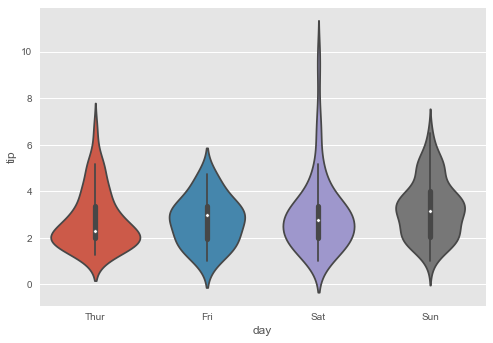

In [4]:
sns.violinplot(x='day', y='tip', data=tips)

In [5]:
y = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -447.78: 100%|███████████████████████████████████████████████| 200000/200000 [00:14<00:00, 14024.64it/s]
Finished [100%]: Average ELBO = -447.77
100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 796.59it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024AA06DC7F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000024AA00EBE10>]], dtype=object)

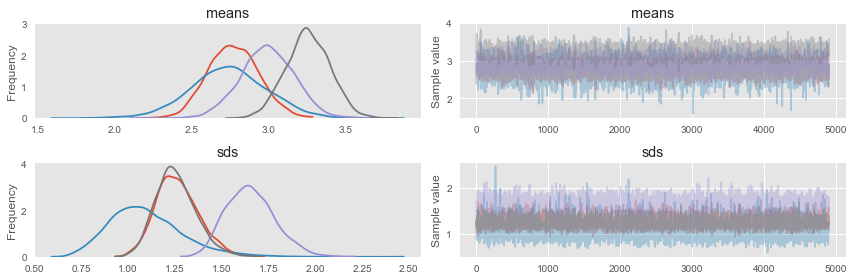

In [6]:
with pm.Model() as comparing_groups:
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(idx)))
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(idx)))
    
    y = pm.Normal('y', mu=means[idx], sd=sds[idx], observed=y)
    
    trace_cg = pm.sample(5000)
chain_cg = trace_cg[100:]
pm.traceplot(chain_cg)

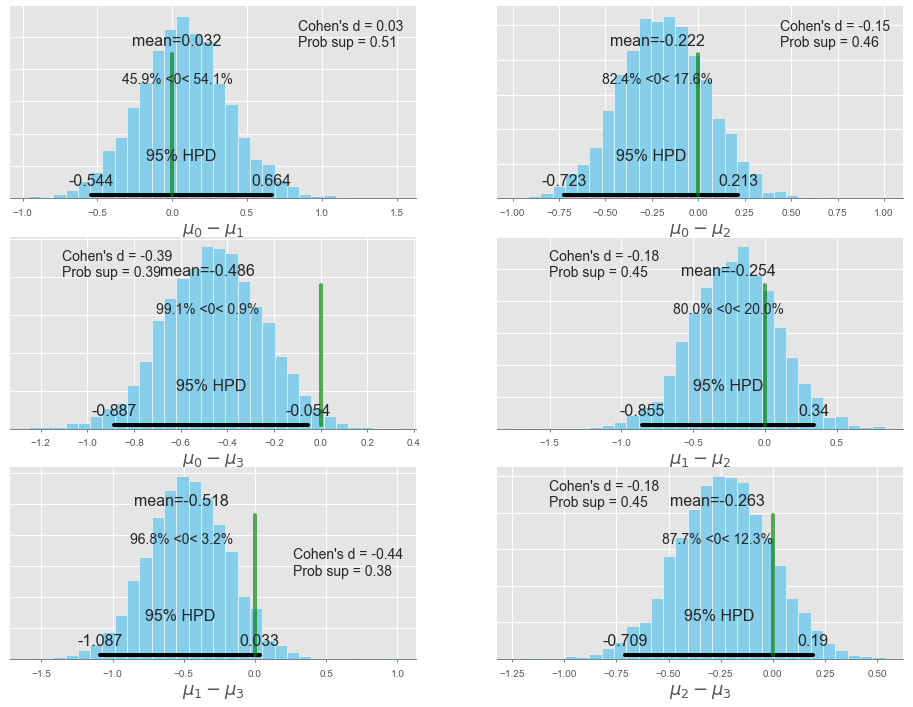

In [13]:
dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(16, 12))

comparisons = [(i, j) for i in range(4) for j in range(i+1, 4)]
pos = [(k, l) for k in range(3) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = chain_cg['means'][:, i]-chain_cg['means'][:, j]
    d_cohen = (means_diff / np.sqrt((chain_cg['sds'][:, i]**2 + chain_cg['sds'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    
    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k, l], color='skyblue')
    ax[k, l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps), alpha=0)
    ax[k, l].set_xlabel('$\mu_{}-\mu_{}$'.format(i, j), fontsize=18)
    ax[k, l].legend(loc=0, fontsize=14)